In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from functools import reduce
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [103]:

START_YEAR = 1963
END_YEAR = 2023

dataframes = [
    pd.read_csv('FORINV.csv'),
    pd.read_csv('GINI.csv'),
    pd.read_csv('HCI.csv'),
    pd.read_csv('INFLATION.csv'),
    pd.read_csv('INTRATE.csv'),
    pd.read_csv('ITAX.csv'),
    pd.read_csv('RCONSPEND.csv'),
    pd.read_csv('RGDP.csv'),
    pd.read_csv('RMEDEARN.csv'),
    pd.read_csv('RMEDHOUINC.csv'),
    pd.read_csv('UNRATE.csv')
]

merged_df = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='left'), dataframes)
new_columns = ['DATE', 'FOREIGN INVESTMENT', 'GINI', 'HUMAN CAPITAL INDEX', 'INFLATION', 'INTEREST RATE', 'HIGHEST INCOME TAX', 'RCONSPEND', 'REAL GDP', 'RMEDEARN', 'RMEDHOUINC', 'UNEMPLOYMENT RATE']
merged_df.columns = new_columns

# Replace xxxx-xx-xx Date format to Year; Only keep one row per year
merged_df = merged_df[merged_df['GINI'].notna()]
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])
merged_df['YEAR'] = merged_df['DATE'].dt.year
merged_df = merged_df.drop(columns = ['DATE'])
merged_df = merged_df.drop_duplicates(subset='YEAR', keep='first')

# Interpolate missing values
merged_df = merged_df.interpolate(method='bfill', limit_direction='backward')
merged_df = merged_df.interpolate(method='ffill', limit_direction='forward')

merged_df.to_csv('merged_df.csv', index=False)

#merged_df

In [104]:
data = pd.read_csv('merged_data.csv')

features = data.drop(['YEAR', 'GINI'], axis=1)  # Select features
target = data['GINI']  # Select Label

# Hyperparameters
input_size = len(new_columns) - 2  # -2 from Year and Gini columns
output_size = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 2500

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create PyTorch DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

hidden_layer_size = 64
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionNN(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets.view(-1, 1))  # Reshape targets for MSELoss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)
    if((epoch+1)%100==0):
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# Evaluate on test data


model.eval()
predictions = []
total_loss = 0


with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets.view(-1, 1))
        predictions.extend(scores.cpu().numpy())

        total_loss += loss.item()

average_loss = total_loss / len(test_loader)
print(f'Test Loss: {average_loss:.4f}')

Epoch [100/2500], Loss: 1249.7073
Epoch [200/2500], Loss: 725.4825
Epoch [300/2500], Loss: 283.1724
Epoch [400/2500], Loss: 93.2222
Epoch [500/2500], Loss: 31.9458
Epoch [600/2500], Loss: 18.0921
Epoch [700/2500], Loss: 14.8096
Epoch [800/2500], Loss: 13.0638
Epoch [900/2500], Loss: 11.6669
Epoch [1000/2500], Loss: 10.5364
Epoch [1100/2500], Loss: 9.5817
Epoch [1200/2500], Loss: 8.7607
Epoch [1300/2500], Loss: 7.9700
Epoch [1400/2500], Loss: 7.2794
Epoch [1500/2500], Loss: 6.6940
Epoch [1600/2500], Loss: 6.1878
Epoch [1700/2500], Loss: 5.7060
Epoch [1800/2500], Loss: 5.2607
Epoch [1900/2500], Loss: 4.8435
Epoch [2000/2500], Loss: 4.4408
Epoch [2100/2500], Loss: 4.0514
Epoch [2200/2500], Loss: 3.6671
Epoch [2300/2500], Loss: 3.2996
Epoch [2400/2500], Loss: 2.9569
Epoch [2500/2500], Loss: 2.6395
Test Loss: 4.2057


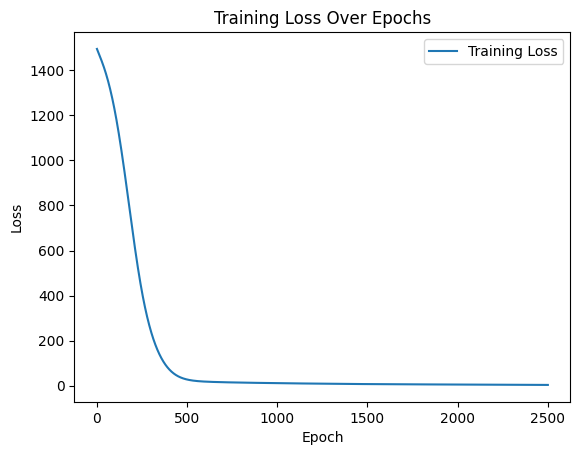

In [ ]:
# Plotting
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

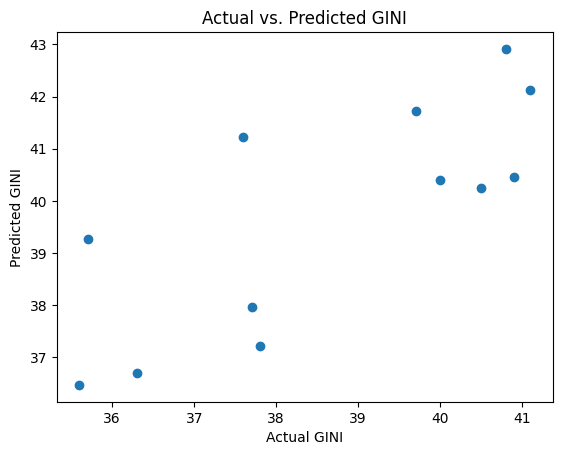

In [ ]:

plt.scatter(y_test, predictions, alpha=1)
plt.xlabel('Actual GINI')
plt.ylabel('Predicted GINI')
plt.title('Actual vs. Predicted GINI')
plt.show()

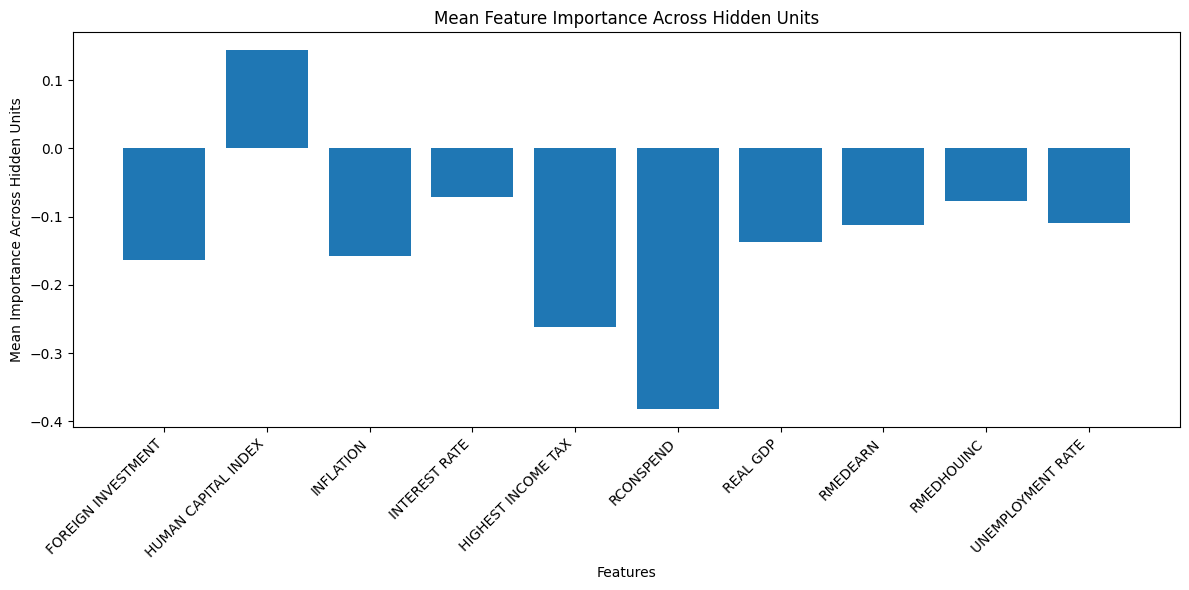

In [ ]:
# Feature Importance Visualization:
weights_fc1 = model.fc1.weight.detach().numpy()

# Compute mean importance across hidden units for each feature
feature_importance_mean = weights_fc1.mean(axis=0)

# Increase figure size
plt.figure(figsize=(12, 6))

# Plotting
plt.bar(range(len(feature_importance_mean)), feature_importance_mean)
plt.xlabel('Features')
plt.ylabel('Mean Importance Across Hidden Units')
plt.title('Mean Feature Importance Across Hidden Units')
plt.xticks(range(len(features.columns)), features.columns, rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

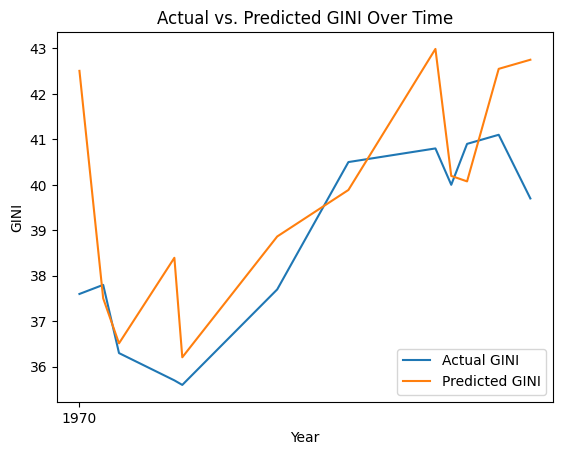

In [108]:
y_test_sorted = y_test.sort_index()
predictions_sorted = pd.Series(predictions, index=y_test.index).sort_index()

# Plotting
plt.plot(y_test_sorted.index, y_test_sorted, label='Actual GINI')
plt.plot(y_test_sorted.index, predictions_sorted, label='Predicted GINI')
plt.xlabel('Year')
plt.ylabel('GINI')
plt.title('Actual vs. Predicted GINI Over Time')
plt.legend()
plt.show()